In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform

In [2]:
GPI = pd.read_csv("./data/fullGPIsample.csv", index_col=0)
GPI = GPI[~GPI['Distance_distance'].isnull()]
GPI = GPI.reset_index(drop=True)
GPI['Age'] = 0

In [3]:
GPI.tail()

,S_Type,Distance_distance,FLUX_I,FLUX_H,Fe_H_Teff,Class,subtype,Mbol,Lum,Teff,Mass,Age
594,B9V,48.5835,NaN,4.622,10860,B,9,0.570,46.558609,10850.0,2.455,0
595,A7III/IV,67.1100,NaN,5.879,7834,A,7,2.445,8.279422,8000.0,1.595,0
596,F6V,35.3895,6.370,5.787,6255,F,6,3.860,2.249055,6400.0,1.160,0
597,K2V,21.9270,7.194,6.007,0,K,2,5.620,0.444631,4930.0,0.738,0
598,A1V,47.0754,NaN,4.949,9057,A,1,1.440,20.892961,9370.0,2.005,0


In [4]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Rearth = 6.3781e6
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26
Year = 3.154e7 # seconds

In [5]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_samplerK(mean=2., std=1.):
    return swarms.Star(M=0.738 * Msun, L=0.738**4 * Lsun, T=4930, d=0)

def star_samplerG(mean=2., std=1.):
    return swarms.Star(M=0.986 * Msun, L=0.986**4 * Lsun, T=5770, d=0)

def star_samplerF(mean=2., std=1.):
    return swarms.Star(M=1.31 * Msun, L=1.31**4 * Lsun, T=7040, d=0)

def star_samplerA(mean=2., std=1.):
    return swarms.Star(M=1.94 * Msun, L=1.94**4 * Lsun, T=9040, d=0)

def star_samplerM(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    
    return swarms.Star(M=0.44*Msun, L=0.023*Lsun, T=3400, d=0) # M2 star

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
        amin = star.d/pc*IWA# AU
        amax = star.d/pc*OWA # AU
        a = loguniform(amin, amax)
        return swarms.Planet(star, M=ms[idx]*Mearth , R=None, a=a*AU, Q=Q, Z='002', age=age)
    
def contrast_scat(A, g, Q, a_pl):
    return (A*g*Q) / (np.pi*a_pl**2)

def cdf(x):
    """create a lin-log cdf function using the points,
        (20, 0.0)
        (135, 0.5)
        (620, 0.9)
    from Bowler & al. 2014."""
    A = -0.785
    B = 0.603
    if isinstance(x, float) or isinstance(x, int):
        return A + B*np.log10(x)
    else:
        f = np.zeros(len(x))
        for i in range(len(x)):
            if x[i] < 20:
                f[i] = 0
            else:
                f[i] = A + B*np.log10(x[i])
                if f[i] > 1.0:
                    f[i] = 1.0
        return f
    
def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  
    
def age_sampler():
    y = uniform(0, 1)
    return inverse_cdf(y)*1e6 * Year

def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

# Find aopt for different initial masses

In [6]:
def aopt(Mtot):
    star = star_samplerM()
    star.d = 10*pc # dummy value
    age = age_sampler()
    planet = draw_planet(star, age)
    if planet is None:
        return aopt(Mtot) # do it again
    Dc = loguniform(1e5, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, Mtot, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=1.65*1e-6)
    return swarm.aopt(t=age)

# Sample

In [7]:
IWA = 0.2 # arcseconds
OWA = 1.2
MWA = (IWA + OWA)/2
lamb = 1.65e-6

M0 = 1*Mearth
aopt = 50 # AU
dopt = aopt/MWA * pc
print('Optimal Distance = {0:.0f} pc'.format(dopt/pc))

Optimal Distance = 71 pc


In [8]:
def sample(M0, dopt, lamb, star_type):
    if star_type == "M":
        star = star_samplerM()
    elif star_type == "K":
        star = star_samplerK()
    elif star_type == "G":
        star = star_samplerG()
    elif star_type == "F":
        star = star_samplerF()
    else:
        star = star_samplerA()
    star.d = distance_sampler(mean=dopt, std=dopt/2.)
    age = age_sampler()
    
    planet = draw_planet(star, age=age)
    if planet is None:
        return sample(M0, dopt, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                            rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    

    CRscatSwarm = swarm.CRscat(g)
    CRscatPlanet = planet.CRscat(g)
    CRthermalPlanet = planet.CRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/pc, planet.M

In [9]:
%%time
seed(0)
M0 = 1e-2*Mearth
star_type = "M"
Nsamples = 300
CRscatSwarmM, CRPlanetM, a, d, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarmM[i], CRPlanetM[i], a[i], d[i], Mplt[i] = sample(M0, dopt, lamb, star_type)

Wall time: 32.4 s


In [10]:
mask = (a/d > IWA) & (a/d < OWA)
logCRscatSwarmM = np.log10(CRscatSwarmM[mask])
logCRPlanetM = np.log10(CRPlanetM[mask])

In [11]:
%%time
seed(0)
M0 = 1e-2*Mearth
star_type = "K"
Nsamples = 300
CRscatSwarmK, CRPlanetK, a, d, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarmK[i], CRPlanetK[i], a[i], d[i], Mplt[i] = sample(M0, dopt, lamb, star_type)

Wall time: 32.8 s


In [12]:
mask = (a/d > IWA) & (a/d < OWA)
logCRscatSwarmK = np.log10(CRscatSwarmK[mask])
logCRPlanetK = np.log10(CRPlanetK[mask])

In [13]:
%%time
seed(0)
M0 = 1.e-2*Mearth
star_type = "G"
Nsamples = 300
CRscatSwarmG, CRPlanetG, a, d, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarmG[i], CRPlanetG[i], a[i], d[i], Mplt[i] = sample(M0, dopt, lamb, star_type)

Wall time: 32.3 s


In [14]:
mask = (a/d > IWA) & (a/d < OWA)
logCRscatSwarmG = np.log10(CRscatSwarmG[mask])
logCRPlanetG = np.log10(CRPlanetG[mask])

In [15]:
%%time
seed(0)
M0 = 1.e-2*Mearth
star_type = "F"
Nsamples = 300
CRscatSwarmF, CRPlanetF, a, d, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarmF[i], CRPlanetF[i], a[i], d[i], Mplt[i] = sample(M0, dopt, lamb, star_type)

Wall time: 29.7 s


In [16]:
mask = (a/d > IWA) & (a/d < OWA)
logCRscatSwarmF = np.log10(CRscatSwarmF[mask])
logCRPlanetF = np.log10(CRPlanetF[mask])

In [17]:
%%time
seed(0)
M0 = 1.e-2*Mearth
star_type = "A"
Nsamples = 300
CRscatSwarmA, CRPlanetA, a, d, Mplt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarmA[i], CRPlanetA[i], a[i], d[i], Mplt[i] = sample(M0, dopt, lamb, star_type)

Wall time: 32 s


In [18]:
mask = (a/d > IWA) & (a/d < OWA)
logCRscatSwarmA = np.log10(CRscatSwarmA[mask])
logCRPlanetA = np.log10(CRPlanetA[mask])

Text(0,0.5,'Number of Planets')

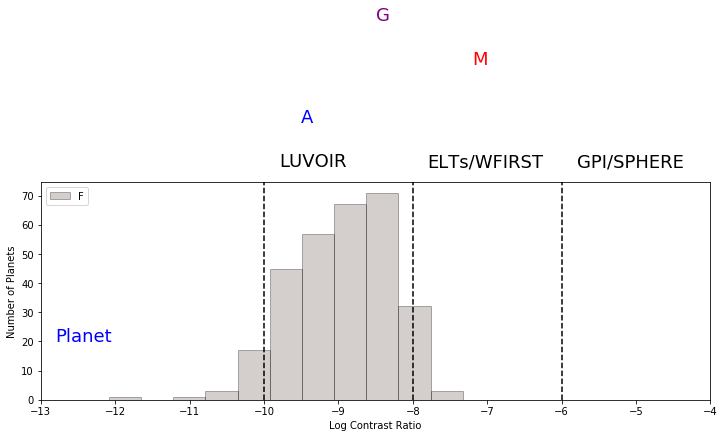

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
#hist, edges, patches = ax.hist(logCRPlanetM, facecolor='b', ec='k')
#hist, edges, patches = ax.hist(logCRscatSwarmM, facecolor=(1, 0, 0), ec='k', alpha=0.3, label='M')
#hist, edges, patches = ax.hist(logCRscatSwarmK, bins=25, facecolor=(0.15,0.6,0.72), ec='k', alpha=0.3, label='K')
#hist, edges, patches = ax.hist(logCRscatSwarmG, facecolor=(0.5,0.0,0.5), ec='k', alpha=0.3, label='G')
hist, edges, patches = ax.hist(logCRscatSwarmF, bins=15, facecolor=(0.45,0.38,0.36), ec='k', alpha=0.3, label='F')
#hist, edges, patches = ax.hist(logCRscatSwarmA, bins=15, facecolor=(0.0,0.0,1), ec='k', alpha=0.3, label='A')


ax.axvline(-6, color='k', linestyle='--')
ax.axvline(-8, color='k', linestyle='--')
ax.axvline(-10, color='k', linestyle='--')

ax.text(-12.8, 20, "Planet", color='b', fontsize=18)
ax.text(-9.8, 80, "LUVOIR", color='k', fontsize=18)
ax.text(-7.8, 80, "ELTs/WFIRST", color='k', fontsize=18)
ax.text(-5.8, 80, "GPI/SPHERE", color='k', fontsize=18)
ax.text(-8.5, 130, "G", color=(0.5, 0, 0.5), fontsize=18)
ax.text(-7.2, 115, "M", color=(1, 0, 0), fontsize=18)
ax.text(-9.5, 95, "A", color=(0, 0, 1), fontsize=18)


#hist, edges, patches = ax.hist(logCRscat0001)
#ax.fill_betweenx([0, 300], -6, -4, facecolor='m', alpha=0.3)
#|ax.set_ylim([0, 250])
ax.legend(loc=2)
ax.set_xlim([-13, -4])
ax.set_xlabel('Log Contrast Ratio')
ax.set_ylabel('Number of Planets')